# Merged Road and Ferry Transport Network

## 0 Setup environment

In [ ]:
import os

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from geopy.distance import geodesic
from networkx import MultiDiGraph
from scipy.spatial import cKDTree

In [2]:
BASE_PATH = "./data"
BOUNDARIES_FILE = os.path.join(BASE_PATH, "boundaries.gpkg")
ROAD_NETWORK_FILE = os.path.join(BASE_PATH, "road_network.graphml")
FERRY_NETWORK_FILE = os.path.join(BASE_PATH, "ferry_network.graphml")

ORIGIN_TOWN = "Legazpi City"

## 1 Load town boundaries

In [3]:
boundaries = gpd.read_file(BOUNDARIES_FILE)
boundaries.head()

,town,province,geometry
0,Bacacay,Albay,"MULTIPOLYGON (((123.84193 13.3341, 123.84204 1..."
1,Camalig,Albay,"MULTIPOLYGON (((123.6559 13.06131, 123.65536 1..."
2,Daraga,Albay,"MULTIPOLYGON (((123.71487 13.03995, 123.71474 ..."
3,Guinobatan,Albay,"MULTIPOLYGON (((123.68355 13.25321, 123.67729 ..."
4,Jovellar,Albay,"MULTIPOLYGON (((123.6559 13.06131, 123.65568 1..."


## 2 Load road transport network

In [4]:
graph_roads = ox.load_graphml(ROAD_NETWORK_FILE)
graph_roads = graph_roads.to_undirected()

for _, data in graph_roads.nodes(data=True):
    data["mode"] = "road"

for _, _, data in graph_roads.edges(data=True):
    data["mode"] = "road"

graph_roads.number_of_nodes(), graph_roads.number_of_edges()

(446869, 460990)

## 3 Initial road-only accessibility analysis

In [5]:
def plot_accessibility(
    G: nx.MultiDiGraph,
    boundaries: gpd.GeoDataFrame,
    origin_town: str,
    title: str,
    filename: str = None,
) -> set[str]:
    origin_point = boundaries[boundaries["town"] == origin_town].union_all().centroid
    origin_node = ox.nearest_nodes(G, origin_point.x, origin_point.y)
    reachable_nodes = {origin_node} | nx.descendants(G, origin_node)

    gdf_reachable_edges = ox.graph_to_gdfs(G.subgraph(reachable_nodes), nodes=False, edges=True)
    gdf_reachable_towns = gpd.sjoin(boundaries, gdf_reachable_edges, how="inner", predicate="intersects")
    reachable_towns = set(gdf_reachable_towns["town"].unique())
    boundaries["accessible"] = boundaries["town"].isin(reachable_towns)

    _, ax = plt.subplots(figsize=(8, 8))

    origin = boundaries[boundaries["town"] == origin_town]
    accessible = boundaries[boundaries["accessible"]]
    inaccessible = boundaries[~boundaries["accessible"]]

    origin.plot(ax=ax, color="peru", edgecolor="white", linewidth=0.5)
    accessible.plot(ax=ax, color="seagreen", edgecolor="white", linewidth=0.5)

    if not inaccessible.empty:
        inaccessible.plot(ax=ax, color="firebrick", edgecolor="white", linewidth=0.5)

    x_min, y_min, x_max, y_max = boundaries.total_bounds
    padding = 0.1
    ax.set_xlim(x_min - padding, x_max + padding)
    ax.set_ylim(y_min - padding, y_max + padding)

    cx.add_basemap(ax, crs=boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

    plt.title(title)
    plt.tight_layout()
    plt.axis("off")

    if filename:
        filepath = os.path.join(BASE_PATH, filename)
        plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()

    return reachable_towns

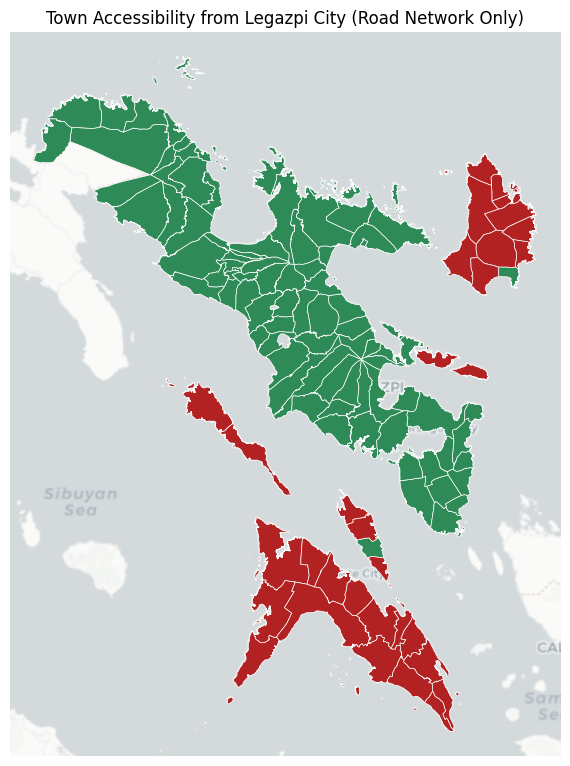

In [6]:
initial_reachable_towns = plot_accessibility(
    G=graph_roads,
    boundaries=boundaries.copy(),
    origin_town=ORIGIN_TOWN,
    title=f"Town Accessibility from {ORIGIN_TOWN} (Road Network Only)",
    filename="initial_accessibility_map.png",
)

## 4 Load ferry transport network

In [7]:
graph_ferry = ox.load_graphml(FERRY_NETWORK_FILE)
graph_ferry = graph_ferry.to_undirected()

for _, data in graph_ferry.nodes(data=True):
    data["mode"] = "ferry"

for _, _, data in graph_ferry.edges(data=True):
    data["mode"] = "ferry"

graph_ferry.number_of_nodes(), graph_ferry.number_of_edges()

(1087, 1060)

## 5 Merge road and ferry networks

In [8]:
def merge_road_and_ferry_networks(G: nx.MultiDiGraph, max_dist_m: int) -> nx.MultiDiGraph:
    nodes = ox.graph_to_gdfs(G, edges=False)[["x", "y", "mode"]]
    ferry_nodes = nodes[nodes["mode"] == "ferry"]
    road_nodes = nodes[nodes["mode"] == "road"]

    tree = cKDTree(road_nodes[["y", "x"]].values)

    for s_id, s_data in ferry_nodes.iterrows():
        s_coord = (s_data["y"], s_data["x"])
        _, idx = tree.query(s_coord, k=1)

        l_id = road_nodes.index[idx]
        l_coord = (road_nodes.iloc[idx]["y"], road_nodes.iloc[idx]["x"])
        dist_m = geodesic(s_coord, l_coord).meters

        if dist_m <= max_dist_m:
            for u, v in [(s_id, l_id), (l_id, s_id)]:
                G.add_edge(u, v, length=dist_m, mode="road")

    return G


def prune_terminal_ferry_nodes(G: nx.MultiDiGraph) -> nx.MultiDiGraph:
    pruned_g = G.copy()
    while True:
        terminal_nodes_to_remove = [
            node for node, degree in pruned_g.degree() if degree == 1 and pruned_g.nodes[node].get("mode") == "ferry"
        ]

        if not terminal_nodes_to_remove:
            # No more nodes to prune, exit the loop
            break

        pruned_g.remove_nodes_from(terminal_nodes_to_remove)

    return pruned_g

In [9]:
graph_merged = nx.compose(graph_roads, graph_ferry)
graph_merged = merge_road_and_ferry_networks(graph_merged, max_dist_m=500)
graph_merged = prune_terminal_ferry_nodes(graph_merged)

graph_merged.number_of_nodes(), graph_merged.number_of_edges()

(447510, 462305)

In [ ]:
graph_merged = MultiDiGraph(graph_merged)
graph_merged = ox.simplify_graph(graph_merged)
graph_merged = graph_merged.to_undirected()

graph_merged.number_of_nodes(), graph_merged.number_of_edges()

(56932, 71895)

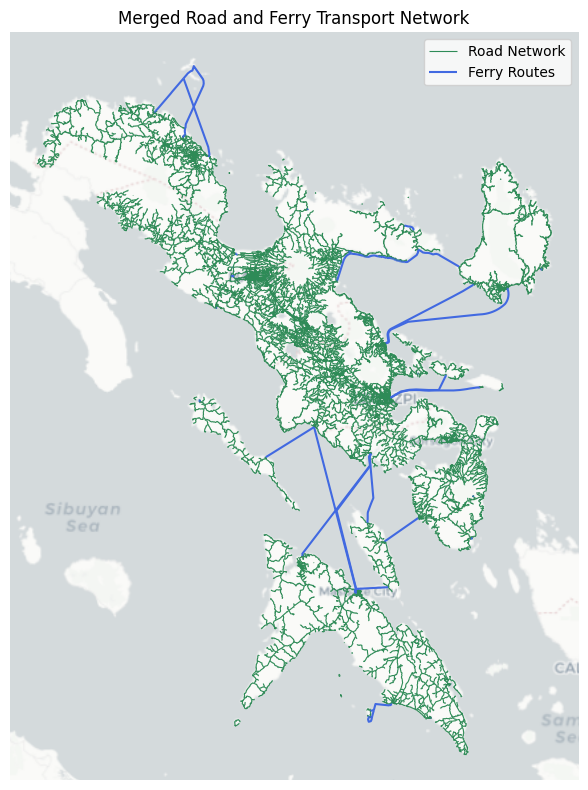

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

_, edges = ox.graph_to_gdfs(graph_merged)
edges = edges.reset_index()

edges[edges["mode"] == "road"].plot(ax=ax, color="seagreen", linewidth=0.8, label="Road Network")
edges[edges["mode"] == "ferry"].plot(ax=ax, color="royalblue", linewidth=1.5, label="Ferry Routes")

x_min, y_min, x_max, y_max = boundaries.total_bounds
padding = 0.1
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)

cx.add_basemap(ax, crs=boundaries.crs, source=cx.providers.CartoDB.Positron, attribution="")

plt.title("Merged Road and Ferry Transport Network")
plt.legend(loc="upper right")
plt.axis("off")
plt.tight_layout()
plt.show()

In [13]:
filename = os.path.join(BASE_PATH, "merged_network_simplified.graphml")
ox.save_graphml(graph_merged, filename)

## 6 Final accessibility analysis

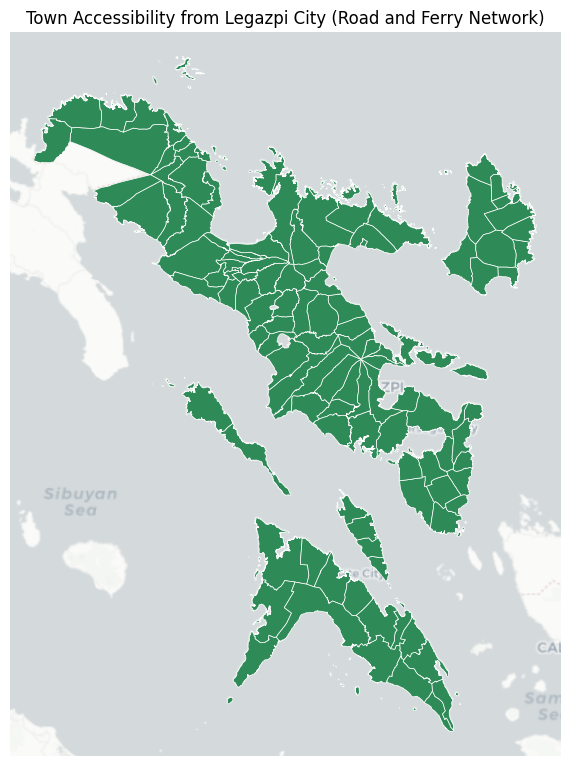

In [14]:
final_reachable_towns = plot_accessibility(
    G=graph_merged,
    boundaries=boundaries.copy(),
    origin_town=ORIGIN_TOWN,
    title=f"Town Accessibility from {ORIGIN_TOWN} (Road and Ferry Network)",
    filename="final_accessibility_map.png",
)

In [15]:
print(f"Accessible towns with roads only: {len(initial_reachable_towns)}")
print(f"Accessible towns with merged network: {len(final_reachable_towns)}")
print(f"Improvement: +{len(final_reachable_towns) - len(initial_reachable_towns)} towns")
print(f"Inaccessible towns: {boundaries[~boundaries['town'].isin(final_reachable_towns)]['town'].unique()}")

Accessible towns with roads only: 81
Accessible towns with merged network: 112
Improvement: +31 towns
Inaccessible towns: []
